In [1]:
import cooler
import gae
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.sparse import coo

from __future__ import division
from __future__ import print_function

import time
import os
from networkx.convert_matrix import from_pandas_adjacency
import networkx as nx
import scipy
import argparse
from scipy import random

In [2]:
# Train on CPU (hide GPU) due to memory constraints
#os.environ['CUDA_VISIBLE_DEVICES'] = ""

import tensorflow as tf
import numpy as np
import scipy.sparse as sp

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

In [3]:
from vgae.model import VGAE

In [4]:
def generate_graph_from_file(filename):
    c = cooler.Cooler(filename)
    mtx = c.matrix(balance=False,sparse=False,as_pixels=False).fetch('chrX')
    if mtx.sum() < 5000:
        return None
#     df = pd.crosstab(mtx.bin1_id, mtx.bin2_id)
#     idx = df.columns.union(df.index)
#     df = df.reindex(index = idx, columns=idx, fill_value=0)
#     features_df = pd.crosstab(mtx.bin1_id, mtx.bin2_id, mtx['count'], aggfunc = sum)
#     idx_df = features_df.columns.union(features_df.index)
#     features_df = features_df.reindex(index = idx_df, columns=idx_df, fill_value=0)
#     features_df.fillna(value=0, inplace=True)
#     adjacency_mat = nx.adjacency_matrix(from_pandas_adjacency(df))
#     features = nx.adjacency_matrix(from_pandas_adjacency(features_df))
    return mtx#adjacency_mat, features

In [5]:
def fill_diag(arr, width=3, val=1):
    tmp = arr.copy()
    for i in range(arr.shape[0]):
        for j in range(width):
            if i+j < arr.shape[0]:
                tmp[i, i+j] = val
            if i - j >= 0:
                tmp[i, i-j] = val
    return tmp

In [20]:
graphs = []
for k in range(50):
    for n in sorted(os.listdir('./dm3/COOL')):
        c = cooler.Cooler('./dm3/COOL/'+n)
        if 5000 < c.info["sum"] < 150000:

            mtx = c.matrix(as_pixels=False, balance=False, sparse=False).fetch("chrX")
            rand = random.randint(0, mtx.shape[0] - 512)
            slc = mtx[rand:rand + 512, rand:rand + 512]
            slc = fill_diag(slc, 2, 1)
            graphs.append(slc)

In [21]:
len(graphs)

1000

In [8]:
import glob
files_list = glob.glob('./dm3/COOL/[A,B]*')

In [9]:
n_nodes = 512

In [24]:
args = {
    'dataset_dir': './data',
    'dataset_name': 'hic',
    'result_dir':'./result',
    'n_hidden':16,
    'dropout': True,
    'keep_prob':0.9,
    'learning_rate':0.01,
    'max_iteration': 5,
    'n_embedding': 5
}

In [25]:
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
with tf.Session(config=config) as sess, tf.device('/job:localhost/replica:0/task:0/device:GPU:0'):
    devices = sess.list_devices()
    print(devices)
    model = VGAE(sess, n_nodes, args)
    model.train(args, graphs)
    predicted_graph = model.forward(graphs[0])

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456), _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 11287530701)]
At step 0 
 Loss: 1.2577414512634277 
 Average Precision: 0.7323344489348104.
Epoch time 376.58715081214905
At step 1 
 Loss: 1.2270524501800537 
 Average Precision: 0.7509758113189839.
Epoch time 376.4417209625244
At step 2 
 Loss: 1.2237236499786377 
 Average Precision: 0.7598101373252162.
Epoch time 376.5127959251404
At step 3 
 Loss: 1.2104601860046387 
 Average Precision: 0.7780493419532093.
Epoch time 376.8364291191101
At step 4 
 Loss: 1.2019741535186768 
 Average Precision: 0.7872222664349199.
Epoch time 376.9807381629944


/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log10
  after removing the cwd from sys.path.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


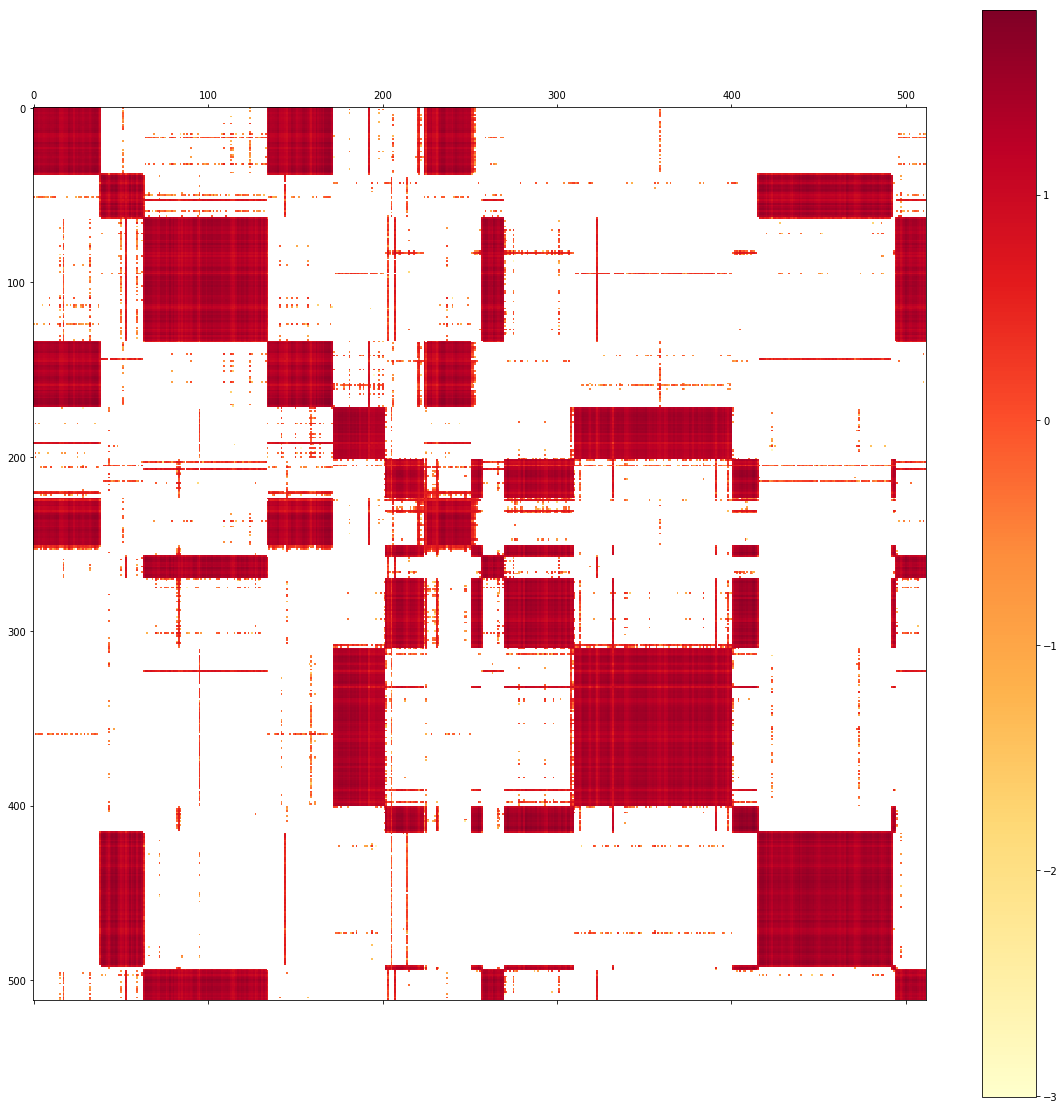

In [28]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)
im = ax.matshow(np.log10(predicted_graph), cmap='YlOrRd')
fig.colorbar(im)
fig.show()

In [ ]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
im = ax.matshow(grpahs[0], cmap='YlOrRd')
fig.colorbar(im)
fig.show()

In [ ]:
predicted_graph.mean(axis=0)

In [ ]:
predicted_graph.var(axis=1)

In [ ]:
predicted_graph.mean()

In [ ]:
batch_gen[0].mean(axis=1)

In [ ]:
batch_gen[0].var(axis=0)